# Training ML models using an Annotated Grain Kernel Image Database

Our group chose a Grain Kernel database as our data for training 3 machine learning models in the MCO. In order to prepare the dataset for the training, we will first make sure that the dataset is clean and uniform (i.e. No duplicate files, uniform aspect ratios, etc).

In [1]:
%pip install Pillow

  Using cached pillow-12.1.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
Using cached pillow-12.1.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from PIL import Image

### Verify file integrity
We will check if every images are accessible and not corrupted

ps: the dataset is not included in git, it should be structured as 
/dataset/images where the maize and rice datasets are in the /images path and the xml files are in /dataset

In [3]:
data_dir = "./dataset/images"
extensions = ".png"

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(extensions):
            img_path = os.path.join(root, file)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image or wrong extension: {img_path}")

### Verify XML Annotations Match Existing Images

Check if every entry in the XML files has a corresponding image file in the dataset.

In [5]:
import xml.etree.ElementTree as ET
from pathlib import Path


def check_xml_images(xml_file, grain_type):
    """Check if all XML entries have corresponding images"""

    tree = ET.parse(xml_file)
    root = tree.getroot()

    xml_ids = []
    for obj in root.findall("object"):
        id_elem = obj.find("ID")
        if id_elem is not None:
            xml_ids.append(id_elem.text)

    # Build list of all actual image files
    image_dir = Path(f"./dataset/images/{grain_type}")
    actual_images = set()

    for img_path in image_dir.rglob("*.png"):
        # Get filename without extension
        actual_images.add(img_path.stem)

    # Find missing images
    missing_images = []
    for xml_id in xml_ids:
        if xml_id not in actual_images:
            missing_images.append(xml_id)

    # Report results
    print(f"Results for {grain_type.upper()}")
    print(f"Total XML entries: {len(xml_ids)}")
    print(f"Missing images: {len(missing_images)}")

    return len(missing_images)


# Check both maize and rice
total_missing = 0
total_missing += check_xml_images("./dataset/maize.xml", "maize")
total_missing += check_xml_images("./dataset/rice.xml", "rice")

Results for MAIZE
Total XML entries: 19000
Missing images: 0
Results for RICE
Total XML entries: 30962
Missing images: 0


# Exploratory Data Analysis

We will analysis the trands and characteristics of the dataset.

Let us first see the distribution of the images for the different categories for each of the grains.

In [8]:
%pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Define disease categories for each grain type
MAIZE_CATEGORIES = ["0_NOR", "1_F&S", "2_SD", "3_MY", "4_AP", "5_BN", "6_HD", "7_IM"]
RICE_CATEGORIES = ["0_NOR", "1_F&S", "2_SD", "3_MY", "4_AP", "5_BN", "6_UN", "7_IM"]

CATEGORIES_MAP = {"maize": MAIZE_CATEGORIES, "rice": RICE_CATEGORIES}

# Count images in each category
base_dir = "./dataset/images"
image_distribution = {}

grain_types = ["maize", "rice"]
splits = ["train", "test"]

for grain in grain_types:
    image_distribution[grain] = {}
    categories = CATEGORIES_MAP[grain]

    for split in splits:
        split_path = os.path.join(base_dir, grain, split)

        if not os.path.exists(split_path):
            print(f"Warning: {split_path} does not exist")
            continue

        image_distribution[grain][split] = {}

        for category in categories:
            category_path = os.path.join(split_path, category)

            image_count = len(
                [f for f in os.listdir(category_path) if f.lower().endswith(".png")]
            )

            image_distribution[grain][split][category] = image_count

✓ Image counting complete!


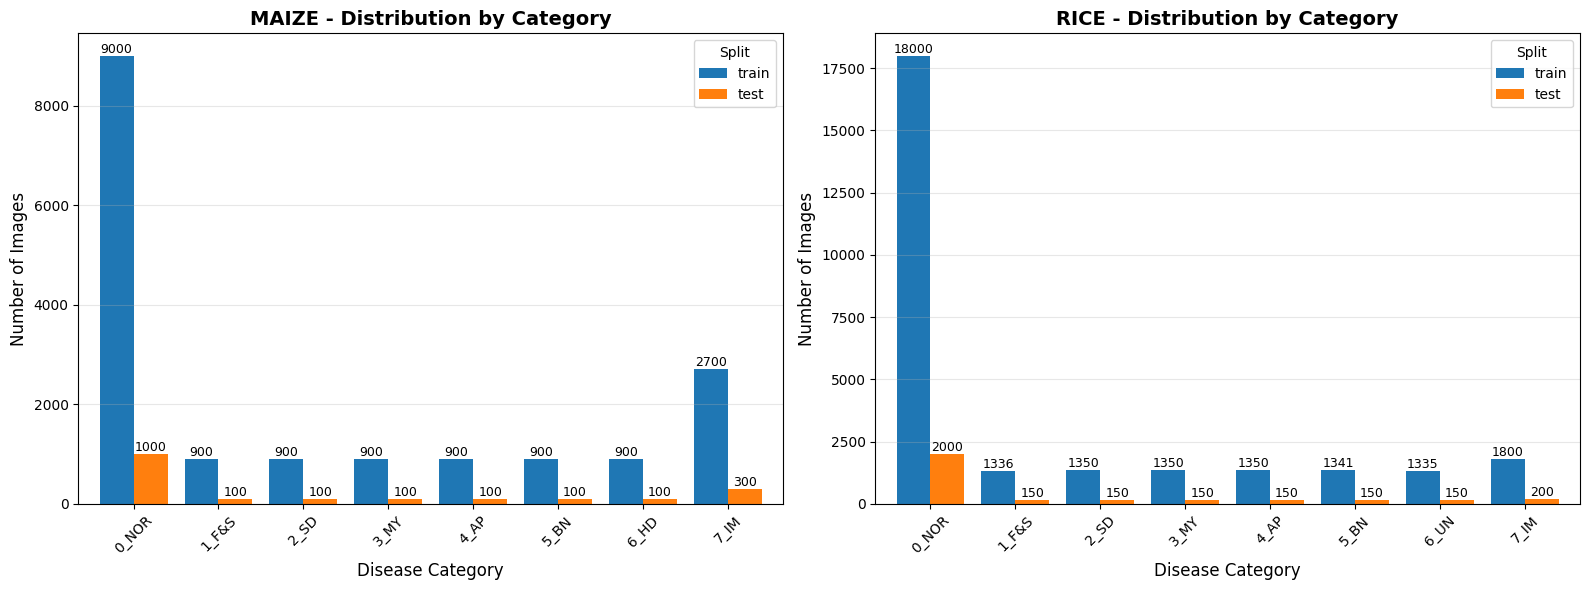

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, grain in enumerate(["maize", "rice"]):
    df = pd.DataFrame(image_distribution[grain])

    df.plot(kind="bar", ax=axes[idx], width=0.8)

    axes[idx].set_title(
        f"{grain.upper()} - Distribution by Category",
        fontsize=14,
        fontweight="bold",
    )
    axes[idx].set_xlabel("Disease Category", fontsize=12)
    axes[idx].set_ylabel("Number of Images", fontsize=12)
    axes[idx].legend(title="Split", fontsize=10)
    axes[idx].grid(axis="y", alpha=0.3)

    # Rotate x-axis labels for readability
    axes[idx].tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt="%d", fontsize=9)

plt.tight_layout()
plt.show()